In [8]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import dataFrameTools
import processGen
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
# from cloudpickle import CloudPickler
import tensorflow_probability as tfp
import random
from random import randrange

In [9]:
def loadData2():
    df=dataFrameTools.normalizeDF(0).astype('float32')
    images=[]
    for i in df.index.values:
        filePath=Path("../Processed Images/Grayscale/(" + str(i) + ").png")
        image=cv2.imread(str(filePath),0)
        images.append(image)
    images=np.array(images)
    #scale image values
    images=images/255.0
    split = train_test_split(df, images, test_size=0.3, random_state=42)
    dtrain, dtv, itrain, itv = split
    dtest, dval, itest, ival = train_test_split(dtv, itv, test_size=0.5, random_state=42)
    itrain=tf.expand_dims(itrain, -1)
    ival=tf.expand_dims(ival, -1)
    itest=tf.expand_dims(itest, -1)
    imdims=np.shape(itrain[1])
    ddims=len(dtrain.columns)
    return dtrain,dval,dtest,itrain,ival,itest,imdims,ddims

def custom_sigmoid_cross_entropy_loss_with_logits(x_true, x_recons_logits):
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits)
    if len(np.shape(x_true))==4:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    else:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1])
    return tf.math.reduce_mean(neg_log_likelihood)

In [10]:
class imVAE:
    def __init__(self, imdims, latent_dim, kl_weight, learning_rate):
        self.dim_x = imdims
        self.latent_dim = latent_dim
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
    def encoder(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(self.latent_dim), scale=1.), 
                                reinterpreted_batch_ndims=1)
        
        model=[layers.InputLayer(input_shape=self.dim_x)]
        
        model.append(layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2),name="e1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
#         model.append(layers.ReLU())
        model.append(layers.Dropout(0.1))
        
        model.append(layers.Conv2D(filters=128, kernel_size=3, strides=(5, 5),name="e2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
#         model.append(layers.ReLU())
        model.append(layers.Dropout(0.1))
        
        model.append(layers.Flatten())
        model.append(layers.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim), name="e3"))
        
        model.append(tfp.layers.IndependentNormal(self.latent_dim, convert_to_tensor_fn=tfp.distributions.Distribution.sample, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=self.kl_weight), name="e4"))
        return keras.Sequential(model, name='encoder')
    
    def decoder(self):
        decoder=keras.Sequential()
        model=[layers.InputLayer(input_shape=(self.latent_dim,))]

        model.append(layers.Dense(30*65*32, name="layer1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
#         model.append(layers.ReLU())
        
        model.append(layers.Dropout(0.1))

        model.append(layers.Reshape(target_shape=(30, 65, 32)))

        model.append(layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',name="d1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
#         model.append(layers.ReLU())
        model.append(layers.Dropout(0.1))

        model.append(layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',name="d2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
#         model.append(layers.ReLU())
        model.append(layers.Dropout(0.1))

#         model.append(layers.UpSampling2D((2,2)))
#         model.append(layers.Conv2D(filters=96, kernel_size=3, strides=(1,1),name="d1"))
#         model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())

#         model.append(layers.UpSampling2D((2,2)))
#         model.append(layers.Conv2D(filters=96, kernel_size=3, strides=(1,1),name="d2"))
#         model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())

        model.append(layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same',name="d3"))
        
#         model.append(keras.layers.Flatten())
#         model.append(tfp.layers.IndependentBernoulli(self.dim_x, name='x_layer'))

        return keras.Sequential(model, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = keras.Input(shape=self.dim_x)
        encoder = self.encoder()
        decoder = self.decoder()
#         encoder.summary()
#         decoder.summary()
        z = encoder(x_input)
        output=decoder(z)

        negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
        
        # compile VAE model
        model = keras.Model(inputs=x_input, outputs=output)
        model.compile(loss=custom_sigmoid_cross_entropy_loss_with_logits, optimizer=keras.optimizers.Adam(self.learning_rate))
        return model



In [5]:
dtrain,dval,dtest,itrain,ival,itest,imdims,ddims=loadData2()
imageVAE=imVAE(imdims, 32, 1, 1e-4).build_vae_keras_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
imhistory = imageVAE.fit(x=itrain, y=itrain, epochs=200, batch_size=32, validation_data=(ival, ival),shuffle=True, callbacks=[callback])

Loaded Imputed Dataframe in  0.8237087726593018 seconds
Epoch 1/200
14/99 [===>..........................] - ETA: 5s - loss: 24829.8086

KeyboardInterrupt: 

In [11]:
from matplotlib.pyplot import figure
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.rc('axes', labelsize=22)     # fontsize of the axes title
plt.rc('axes', titlesize=22) 
figure(figsize=(8, 5))
plt.plot(imhistory.history['loss'],color='#173000')
plt.plot(imhistory.history['val_loss'], color='#b73000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

NameError: name 'imhistory' is not defined

<Figure size 576x360 with 0 Axes>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


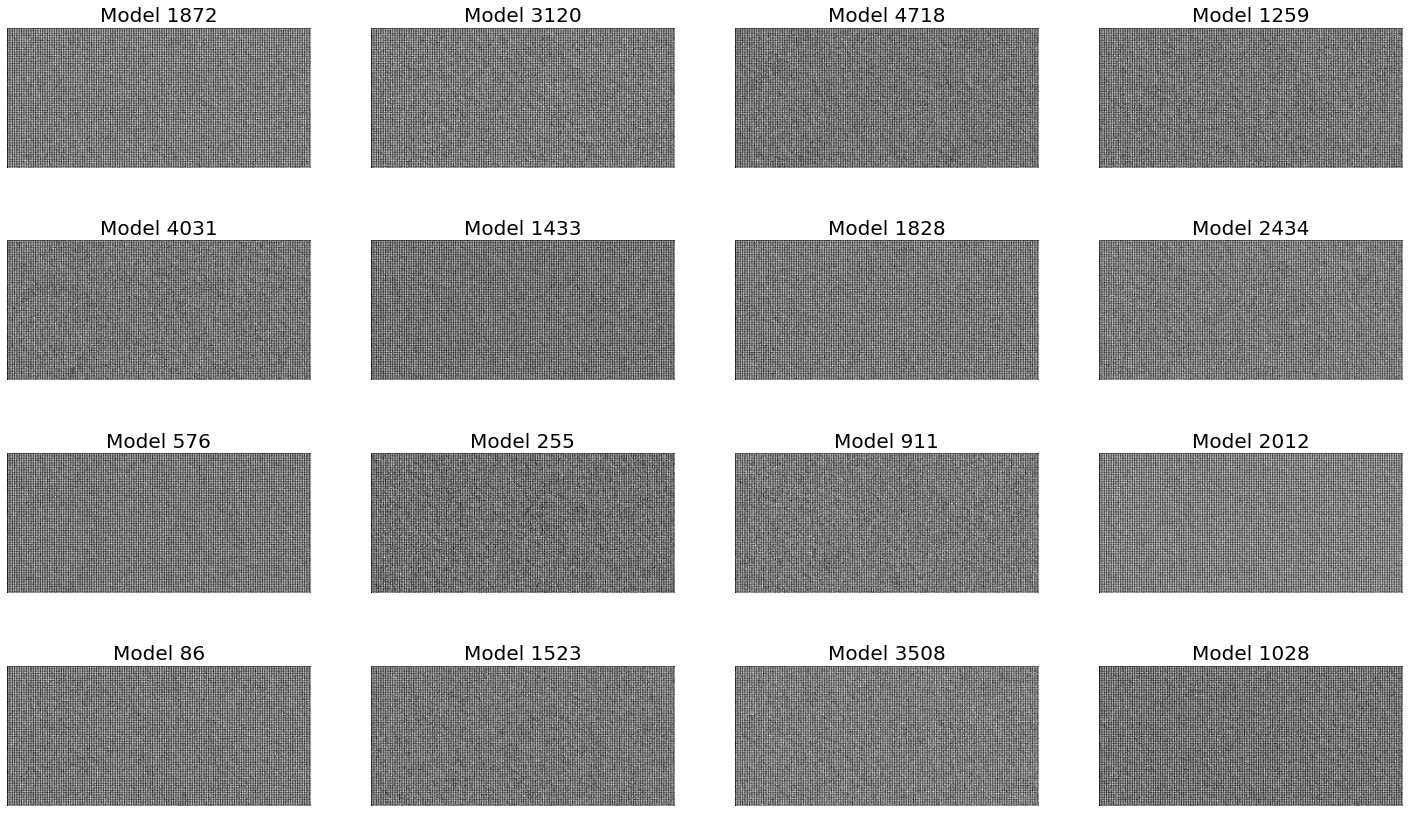

In [12]:
preds=(tf.math.sigmoid(imageVAE.predict(x=itest[:16])))
fig = plt.figure(figsize=(25, 15))
for i in range(16):
    idx=dtest.index[i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(preds[i,:,:,:], cmap="gray")
    plt.title("Model " + str(idx), fontsize=20)
    plt.axis('off')
    

In [13]:
class dVAE:
    def __init__(self, datadims, latent_dim, kl_weight, learning_rate):
        self.dim_x = datadims
        self.latent_dim = latent_dim
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
    def encoder(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(self.latent_dim), scale=1.), 
                                reinterpreted_batch_ndims=1)
        
        model=[layers.InputLayer(input_shape=self.dim_x)]
        
        model.append(layers.Dense(200, name="e0"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))

        model.append(layers.Dense(200, name="e1"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="e2"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="e3"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="e4"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim), name="e5"))
        
        model.append(tfp.layers.IndependentNormal(self.latent_dim, convert_to_tensor_fn=tfp.distributions.Distribution.sample, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=self.kl_weight), name="e6"))
        return keras.Sequential(model, name='encoder')
    
    
    def decoder(self):
        decoder=keras.Sequential()
        model=[layers.InputLayer(input_shape=(self.latent_dim,))]

        model.append(layers.Dense(200, name="d0"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))

        model.append(layers.Dense(200, name="d1"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="d2"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="d3"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="d4"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        
        model.append(layers.Dense(self.dim_x, name="d5"))

        return keras.Sequential(model, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = keras.Input(shape=self.dim_x)
        encoder = self.encoder()
        decoder = self.decoder()
#         encoder.summary()
#         decoder.summary()
        z = encoder(x_input)
        output=decoder(z)
        negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
        
        # compile VAE model
        model = keras.Model(inputs=x_input, outputs=output)
        model.compile(loss=custom_sigmoid_cross_entropy_loss_with_logits, optimizer=keras.optimizers.Adam(self.learning_rate))
        return model

In [40]:
dtrain,dval,dtest,itrain,ival,itest,imdims,ddims=loadData2()
dataVAE=dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)
history = dataVAE.fit(x=dtrain, y=dtrain, epochs=5000, batch_size=128, validation_data=(dval, dval), callbacks=[callback])

Loaded Imputed Dataframe in  0.8056914806365967 seconds
Epoch 1/5000


Exception ignored in: <function ScopedTFFunction.__del__ at 0x000001A2E9CDCA60>
Traceback (most recent call last):
  File "C:\Users\Lyle\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 110, in __del__
    self.deleter(self.func)
KeyboardInterrupt: 


25/25 [==============================] - 3s 33ms/step - loss: 1140.2506 - val_loss: 1476.8894
Epoch 2/5000
25/25 [==============================] - 1s 22ms/step - loss: 708.7415 - val_loss: 1149.8599
Epoch 3/5000
25/25 [==============================] - 1s 23ms/step - loss: 635.7895 - val_loss: 890.4323
Epoch 4/5000
25/25 [==============================] - 1s 21ms/step - loss: 608.6582 - val_loss: 700.9245
Epoch 5/5000
25/25 [==============================] - 1s 21ms/step - loss: 596.0182 - val_loss: 627.4347
Epoch 6/5000
25/25 [==============================] - 1s 21ms/step - loss: 587.6566 - val_loss: 598.7764
Epoch 7/5000
25/25 [==============================] - 1s 21ms/step - loss: 581.3386 - val_loss: 587.9929
Epoch 8/5000
25/25 [==============================] - 1s 21ms/step - loss: 577.0038 - val_loss: 581.3533
Epoch 9/5000
25/25 [==============================] - 1s 21ms/step - loss: 574.2264 - val_loss: 575.4582
Epoch 10/5000
25/25 [==============================] - 1s 21ms/st

Epoch 155/5000
25/25 [==============================] - 1s 21ms/step - loss: 512.7330 - val_loss: 523.6367
Epoch 156/5000
25/25 [==============================] - 1s 21ms/step - loss: 512.5678 - val_loss: 522.9132
Epoch 157/5000
25/25 [==============================] - 1s 21ms/step - loss: 512.3253 - val_loss: 523.5991
Epoch 158/5000
25/25 [==============================] - 1s 21ms/step - loss: 511.8798 - val_loss: 523.0786
Epoch 159/5000
25/25 [==============================] - 1s 21ms/step - loss: 511.7282 - val_loss: 522.8831
Epoch 160/5000
25/25 [==============================] - 1s 21ms/step - loss: 512.0513 - val_loss: 523.7145
Epoch 161/5000
25/25 [==============================] - 1s 21ms/step - loss: 511.4904 - val_loss: 524.0239
Epoch 162/5000
25/25 [==============================] - 1s 21ms/step - loss: 511.5170 - val_loss: 523.4787
Epoch 163/5000
25/25 [==============================] - 1s 21ms/step - loss: 511.2693 - val_loss: 522.9858
Epoch 164/5000
25/25 [===============

KeyboardInterrupt: 

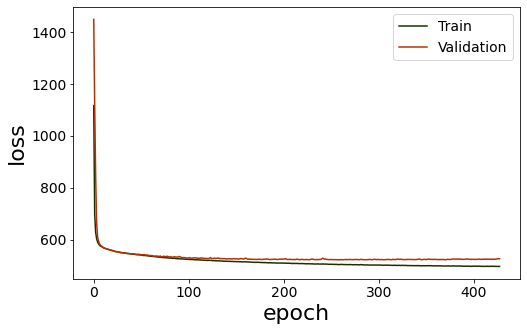

In [67]:
from matplotlib.pyplot import figure
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.rc('axes', labelsize=22)     # fontsize of the axes title
plt.rc('axes', titlesize=22) 
figure(figsize=(8, 5))
plt.plot(history.history['loss'],color='#173000')
plt.plot(history.history['val_loss'], color='#b73000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [29]:
df=dataFrameTools.loadScaledDF().astype('float32')
preddata=df.loc[[2,3,4,10,12,14,18,22,45,50,56,61,72,80,85,91]]

numpred=16
# preds=(tf.math.sigmoid(dataVAE.predict(x=dtest[:numpred]))).numpy()
# preddf=pd.DataFrame(data=preds, columns=dtest.columns, index=dtest.index[:numpred])
preds=(tf.math.sigmoid(dataVAE.predict(x=preddata))).numpy()
preddf=pd.DataFrame(data=preds, columns=dtest.columns, index=preddata.index) 
preddf.to_csv('../Data/vaegendf.csv')  

Loaded Scaled Dataframe in  1.053903579711914 seconds


In [30]:
processGen.processGen("vaegendf")

Loaded Imputed Dataframe in  0.7776675224304199 seconds
Inverse Scaled Dataframe Successfully exported to CSV in  0.9247937202453613 seconds
One-hot encoding 106 features
Onehot Completed in 4.093013286590576 seconds
Loaded Imputed Dataframe in  0.8151991367340088 seconds
2
3
4
10
12
14
18
22
45
50
56
61
72
80
85
91


In [15]:
#Random interpolation of VAE latent space
df=pd.read_csv("../data/BIKED_normalized.csv", index_col=0)
numgen=16
latent=dataVAE.layers[1].predict(dtest.loc[[181,4007]])
l1=latent[0]
interpolated=np.zeros((numgen, len(l1)))
for i in range(numgen):
    idx1=dtest.index[random.randint(0,len(dtest.index)-1)]
    idx2=dtest.index[random.randint(0,len(dtest.index)-1)]
    twobikes=dtest.loc[[idx1,idx2]]
    latent=dataVAE.layers[1].predict(twobikes)
    l1=latent[0]
    l2=latent[1]
    scale=random.uniform(0,1)
    interpolated[i]=l1+scale*(l2-l1)
res=(tf.math.sigmoid(dataVAE.layers[2].predict(interpolated))).numpy()
indices=["vaeinterpolgen" +str(i) for i in range(numgen)]
interpolgendf=pd.DataFrame(res, index=indices, columns=df.columns)
interpolgendf.to_csv("../data/vaeinterpolgendf.csv")

NameError: name 'dataVAE' is not defined

In [14]:
processGen.processGen("vaeinterpolgendf")

FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\vaeinterpolgendf.csv'

In [60]:
#Random Generation from latent distribution of test batch
df=pd.read_csv("../data/BIKED_normalized.csv", index_col=0)
numgen=10000
# latent=dataVAE.layers[1].predict(dtest.loc[[181,4007]])
latent=dataVAE.layers[1].predict(dtest)
print(np.shape(latent))
generated=np.zeros((numgen, len(latent[0])))
for i in range(numgen):
    for j in range(len(latent[0])):
        idx=randrange(len(latent[:,0]))
        generated[i,j]=latent[idx, j]
res=(tf.math.sigmoid(dataVAE.layers[2].predict(generated))).numpy()
indices=["vaerand" +str(i) for i in range(numgen)]
interpolgendf=pd.DataFrame(res, index=indices, columns=df.columns)
interpolgendf.to_csv("../data/vaeranddf.csv")

(1128, 128)


In [53]:
#Interpolation and Extrapolation between two models in Parametric VAE space

twobikes=dtest.loc[[181,4007]]
latent=dataVAE.layers[1].predict(twobikes)
l1=latent[0]
l2=latent[1]
#interpolation code
num_interp=3
interpolated=np.zeros((num_interp, len(l1)))
for i in range(num_interp):
    interpolated[i]=l1+(l2-l1)*(i)/(num_interp+1)
res=(tf.math.sigmoid(dataVAE.layers[2].predict(interpolated))).numpy()
indexnames=[str(i+1)+"Interpolated Latent" for i in range(num_interp)]
interpolatedf=pd.DataFrame(data=res, index=indexnames, columns=df.columns)
interpolatedf.to_csv("../data/interpoldf.csv")

#extrapolation code
num_extrap=3
extrapolated=np.zeros((num_extrap, len(l1)))
for i in range(num_extrap):
    extrapolated[i]=l2+(l2-l1)*(i+1)/3
res=(tf.math.sigmoid(dataVAE.layers[2].predict(extrapolated))).numpy()
indexnames=[str(i+1)+"Extrapolated Latent" for i in range(num_extrap)]
extrapolatedf=pd.DataFrame(data=res, index=indexnames, columns=df.columns)
extrapolatedf.to_csv("../data/extrapoldf.csv")


In [52]:
processGen.processGen("interpoldf")
processGen.processGen("extrapoldf")

Loaded Imputed Dataframe in  0.7721621990203857 seconds
Inverse Scaled Dataframe Successfully exported to CSV in  0.8937671184539795 seconds
One-hot encoding 106 features
Onehot Completed in 3.703176975250244 seconds
Loaded Imputed Dataframe in  0.776667594909668 seconds
1Interpolated Latent
2Interpolated Latent
3Interpolated Latent
Loaded Imputed Dataframe in  0.7881758213043213 seconds
Inverse Scaled Dataframe Successfully exported to CSV in  0.9097800254821777 seconds
One-hot encoding 106 features
Onehot Completed in 3.7417123317718506 seconds
Loaded Imputed Dataframe in  0.7771668434143066 seconds
1Extrapolated Latent
2Extrapolated Latent
3Extrapolated Latent


In [57]:
#Random latent space sampling code from set range
latent=dataVAE.layers[1].predict(dtest.iloc[[0,1]])[1]
numgen=16
r=np.random.rand(numgen,len(latent))*4-2
res=(tf.math.sigmoid(dataVAE.layers[2].predict(r))).numpy()
indices=["vaerand" +str(i) for i in range(numgen)]
randdf=pd.DataFrame(data=res, columns=dtest.columns, index=indices)
randdf.to_csv("../data/vaeranddf.csv")
# dataFrameTools.deNormalizeDF("randdf.csv")
# dataFrameTools.deOH()
# dataFrameTools.genBCAD()

In [58]:
processGen.processGen("vaeranddf")

Loaded Imputed Dataframe in  0.769660472869873 seconds
Inverse Scaled Dataframe Successfully exported to CSV in  0.9107804298400879 seconds
One-hot encoding 106 features
Onehot Completed in 3.784749746322632 seconds
Loaded Imputed Dataframe in  0.7991852760314941 seconds
vaerand0
vaerand1
vaerand2
vaerand3
vaerand4
vaerand5
vaerand6
vaerand7
vaerand8
vaerand9
vaerand10
vaerand11
vaerand12
vaerand13
vaerand14
vaerand15


In [24]:
from sklearn import preprocessing
df=pd.read_csv('../Data/vaeranddf.csv', index_col=0)
ImpDF=dataFrameTools.loadImpDF()
min_max_scaler = preprocessing.MinMaxScaler()
# min_max_scaler = preprocessing.StandardScaler()
min_max_scaler.fit(ImpDF.values)
invscaled=min_max_scaler.inverse_transform(df)   
invdf = pd.DataFrame(invscaled, columns=df.columns, index=df.index.values)
valid=checkvalid(invdf,0)
print(len(valid))
valid=valid[:numgen]
sampled=invdf.loc[valid]
sampled.index=["vae"+ str(i) for i in range(4512)]
# sampled.index=["CTGAN"+ str(i) for i in range(len(sampled.index))]
sampled.to_csv("../data/vaeranddf.csv")

KeyboardInterrupt: 

In [59]:
class combVAE:
    def __init__(self, comb_input, latent_dim, kl_weight, learning_rate):
        self.comb_input=comb_input
        self.datadims = comb_input[0]
        self.imdims=comb_input[1]
        self.latent_dim = latent_dim
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        
    def dencoder(self):
        model=[layers.InputLayer(input_shape=self.datadims)]
        
        model.append(layers.Dense(200, name="e0"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))

        model.append(layers.Dense(200, name="e1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))
        
        model.append(layers.Dense(200, name="e2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))
        
        model.append(layers.Dense(200, name="e3"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))
        
        model.append(layers.Dense(200, name="e4"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))
        
        return keras.Sequential(model, name='dencoder')
    
    def imencoder(self):
        
        model=[layers.InputLayer(input_shape=self.imdims)]
        
        model.append(layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2),name="e1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))
        
        model.append(layers.Conv2D(filters=128, kernel_size=3, strides=(5, 5),name="e2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))
        
        model.append(layers.Flatten())
        model.append(layers.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim), name="e3"))
        
        return keras.Sequential(model, name='imencoder')
        
    def encoder(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(self.latent_dim), scale=1.), 
                                reinterpreted_batch_ndims=1)
        denc=dencoder(self)
        imenc=imencoder(self)
        combinedInput=concatenate([denc.output, imenc.output])
        x=layers.Dense(200, name="f1")(combinedInput)
        x=layers.LeakyReLU()(x)
        x=layers.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim), name="f1")(x)
        
        x= tfp.layers.IndependentNormal(self.latent_dim, convert_to_tensor_fn=tfp.distributions.Distribution.sample, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=self.kl_weight), name="e6")(x)
        return x
    
    def decoder(self):
        decoder=keras.Sequential()
        model=[layers.InputLayer(input_shape=(self.latent_dim,))]

        model.append(layers.Dense(30*65*32, name="layer1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))

        model.append(layers.Reshape(target_shape=(30, 65, 32)))

        model.append(layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',name="d1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))

        model.append(layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',name="d2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))

        model.append(layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same',name="d3"))

        return keras.Sequential(model, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = keras.Input(shape=self.comb_input)
        encoder = self.encoder()
        decoder = self.decoder()
        encoder.summary()
        decoder.summary()
        z = encoder(x_input)
        output=decoder(z)
        negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
        
        # compile VAE model
        model = keras.Model(inputs=x_input, outputs=output)
        model.compile(loss=custom_sigmoid_cross_entropy_loss_with_logits, optimizer=keras.optimizers.Adam(self.learning_rate))
        return model

In [60]:
dtrain,dtest,itrain,itest,imdims,ddims=loadData2()
combdims=[ddims,imdims]
combVAE=combVAE(combdims, 128, 1, 1e-4).build_vae_keras_model()

Loaded Scaled Dataframe in  1.0126619338989258 seconds


TypeError: Error converting shape to a TensorShape: Dimension value must be integer or None or have an __index__ method, got value 'TensorShape([120, 260, 1])' with type '<class 'tensorflow.python.framework.tensor_shape.TensorShape'>'.

In [ ]:
preds=(tf.math.sigmoid(combVAE.predict(x=itest[:16])))
fig = plt.figure(figsize=(25, 15))
for i in range(16):
    idx=dtest.index[i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(preds[i,:,:,:], cmap="gray")
    plt.title("Model " + str(idx), fontsize=20)